![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 2. Text Preprocessing with Spark NLP

**Note** Read this article if you want to understand the basic concepts in Spark NLP.

https://towardsdatascience.com/introduction-to-spark-nlp-foundations-and-basic-components-part-i-c83b7629ed59

## 1. Annotators and Transformer Concepts

In Spark NLP, all Annotators are either Estimators or Transformers as we see in Spark ML. An Estimator in Spark ML is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model. A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer that transforms a DataFrame with features into a DataFrame with predictions.
In Spark NLP, there are two types of annotators: AnnotatorApproach and AnnotatorModel
AnnotatorApproach extends Estimators from Spark ML, which are meant to be trained through fit(), and AnnotatorModel extends Transformers which are meant to transform data frames through transform().
Some of Spark NLP annotators have a Model suffix and some do not. The model suffix is explicitly stated when the annotator is the result of a training process. Some annotators, such as Tokenizer are transformers but do not contain the suffix Model since they are not trained, annotators. Model annotators have a pre-trained() on its static object, to retrieve the public pre-trained version of a model.
Long story short, if it trains on a DataFrame and produces a model, it’s an AnnotatorApproach; and if it transforms one DataFrame into another DataFrame through some models, it’s an AnnotatorModel (e.g. WordEmbeddingsModel) and it doesn’t take Model suffix if it doesn’t rely on a pre-trained annotator while transforming a DataFrame (e.g. Tokenizer).

In [6]:
%sh
wget https://gist.githubusercontent.com/vkocaman/e091605f012ffc1efc0fcda170919602/raw/fae33d25bd026375b2aaf1194b68b9da559c4ac4/annotators.csv

--2020-04-20 14:24:18-- https://gist.githubusercontent.com/vkocaman/e091605f012ffc1efc0fcda170919602/raw/fae33d25bd026375b2aaf1194b68b9da559c4ac4/annotators.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.52.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3136 (3.1K) [text/plain]
Saving to: ‘annotators.csv’

 0K ... 100% 72.1M=0s

2020-04-20 14:24:18 (72.1 MB/s) - ‘annotators.csv’ saved [3136/3136]

In [7]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v2.4.5 
 Master 
 spark://10.164.252.9:7077 
 AppName 
 Databricks Shell

In [8]:
import pandas as pd

df = pd.read_csv("annotators.csv")

display(df)

Annotator,Description,Version,Annotator Approach,Annotator Model
Tokenizer*,Identifies tokens with tokenization open standards,Opensource,-,+
Normalizer*,Removes all dirty characters from text,Opensource,-,+
Stemmer*,Returns hard'-stems out of words with the objective of retrieving the meaningful part of the word,Opensource,+,-
Lemmatizer*,Retrieves lemmas out of words with the objective of returning a base dictionary word,Opensource,-,+
RegexMatcher*,Uses a reference file to match a set of regular expressions and put them inside a provided key.,Opensource,+,+
TextMatcher*,Annotator to match entire phrases (by token) provided in a file against a Document,Opensource,+,+
Chunker*,Matches a pattern of part'-of'-speech tags in order to return meaningful phrases from document,Opensource,+,-
DateMatcher*,Reads from different forms of date and time expressions and converts them to a provided date format,Opensource,+,-
SentenceDetector*,Finds sentence bounds in raw text. Applies rules from Pragmatic Segmenter,Opensource,+,-
DeepSentenceDetector*,Finds sentence bounds in raw text. Applies a Named Entity Recognition DL model,Opensource,+,-


By convention, there are three possible names:

Approach — Trainable annotator

Model — Trained annotator

nothing — Either a non-trainable annotator with pre-processing
step or shorthand for a model

So for example, Stemmer doesn’t say Approach nor Model, however, it is a Model. On the other hand, Tokenizer doesn’t say Approach nor Model, but it has a TokenizerModel(). Because it is not “training” anything, but it is doing some preprocessing before converting into a Model.
When in doubt, please refer to official documentation and API reference.
Even though we will do many hands-on practices in the following articles, let us give you a glimpse to let you understand the difference between AnnotatorApproach and AnnotatorModel.
As stated above, Tokenizer is an AnnotatorModel. So we need to call fit() and then transform().

Now let’s see how this can be done in Spark NLP using Annotators and Transformers. Assume that we have the following steps that need to be applied one by one on a data frame.

- Split text into sentences
- Tokenize
- Normalize
- Get word embeddings

What’s actually happening under the hood?

When we fit() on the pipeline with Spark data frame (df), its text column is fed into DocumentAssembler() transformer at first and then a new column “document” is created in Document type (AnnotatorType). As we mentioned before, this transformer is basically the initial entry point to Spark NLP for any Spark data frame. Then its document column is fed into SentenceDetector() (AnnotatorApproach) and the text is split into an array of sentences and a new column “sentences” in Document type is created. Then “sentences” column is fed into Tokenizer() (AnnotatorModel) and each sentence is tokenized and a new column “token” in Token type is created. And so on.

In [12]:
import sparknlp

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

Spark NLP version 2.4.2
Apache Spark version: 2.4.5

In [13]:
text = 'Peter Parker is a nice guy and lives in New York'

spark_df = spark.createDataFrame([[text]]).toDF("text")

spark_df.show(truncate=False)

+------------------------------------------------+
text |
+------------------------------------------------+
Peter Parker is a nice guy and lives in New York|
+------------------------------------------------+

In [14]:
# or we can even create a spark dataframe from pandas ataframe
temp_spark_df = spark.createDataFrame(df)

temp_spark_df.show()

+--------------------+--------------------+----------+------------------+---------------+
 Annotator| Description| Version|Annotator Approach|Annotator Model|
+--------------------+--------------------+----------+------------------+---------------+
 Tokenizer*|Identifies tokens...|Opensource| -| +|
 Normalizer*|Removes all dirty...|Opensource| -| +|
 Stemmer*|Returns hard'-ste...|Opensource| +| -|
 Lemmatizer*|Retrieves lemmas ...|Opensource| -| +|
 RegexMatcher*|Uses a reference ...|Opensource| +| +|
 TextMatcher*|Annotator to matc...|Opensource| +| +|
 Chunker*|Matches a pattern...|Opensource| +| -|
 DateMatcher*|Reads from differ...|Opensource| +| -|
 SentenceDetector*|Finds sentence bo...|Opensource| +| -|
DeepSentenceDetec...|Finds sentence bo...|Opensource| +| -|
 POSTagger|Sets a Part'-Of'-...|Opensource| +| +|
ViveknSentimentDe...|Scores a sentence...|Opensource| +| +|
 SentimentDetector*|Scores a sentence...|Opensource| +| +|
 WordEmbeddings*|Word Embeddings l...|Opensource| +| +|
 BertEmbeddings*|Bert Embeddings t...|Opensource| +| -|
 NerCrf|Named Entity reco...|Opensource| +| +|
 NerDL|This Named Entity...|Opensource| +| +|
 NorvigSweeting|This annotator re...|Opensource| +| +|
 SymmetricDelete|This spell checke...|Opensource| +| +|
 ContextSpellChecker|Utilizes tensorfl...|Opensource| +| +|
+--------------------+--------------------+----------+------------------+---------------+
only showing top 20 rows

In [15]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jupyter/annotation/english/spark-nlp-basics/sample-sentences-en.txt

In [16]:
with open('sample-sentences-en.txt') as f:
  print (f.read())

Peter is a very good person.
My life in Russia is very interesting.
John and Peter are brothers. However they don't support each other that much.
Lucas Nogal Dunbercker is no longer happy. He has a good car though.
Europe is very culture rich. There are huge churches! and big houses!

In [17]:
#and we need to copy this to dbfs to be able to read by Spark
dbutils.fs.cp("file:/databricks/driver/sample-sentences-en.txt", "dbfs:/")

Out[14]: True

In [18]:
spark_df = spark.read.text('sample-sentences-en.txt').toDF('text')

spark_df.show(truncate=False)

+-----------------------------------------------------------------------------+
text |
+-----------------------------------------------------------------------------+
Peter is a very good person. |
My life in Russia is very interesting. |
John and Peter are brothers. However they don't support each other that much.|
Lucas Nogal Dunbercker is no longer happy. He has a good car though. |
Europe is very culture rich. There are huge churches! and big houses! |
+-----------------------------------------------------------------------------+

In [19]:
spark_df.createOrReplaceTempView("sample_spark_df_view")


In [20]:
%scala

var scalaDF = spark.sql("select * from sample_spark_df_view")

scalaDF.show()


+--------------------+
 text|
+--------------------+
Peter is a very g...|
My life in Russia...|
John and Peter ar...|
Lucas Nogal Dunbe...|
Europe is very cu...|
+--------------------+

scalaDF: org.apache.spark.sql.DataFrame = [text: string]

In [21]:
spark_df.select('text').show(truncate=False)

pythonDF = spark.sql("select * from my_table")

pythonDF.show()

In [22]:
textFiles = spark.sparkContext.wholeTextFiles("./*.txt",4)
    
spark_df = textFiles.toDF(schema=['path','file_content'])

spark_df.show(truncate=30)

In [23]:
spark_df.select('file_content').take(1)

### Transformers

what are we going to do if our DataFrame doesn’t have columns in those type? Here comes transformers. In Spark NLP, we have five different transformers that are mainly used for getting the data in or transform the data from one AnnotatorType to another. Here is the list of transformers:

`DocumentAssembler`: To get through the NLP process, we need to get raw data annotated. This is a special transformer that does this for us; it creates the first annotation of type Document which may be used by annotators down the road.

`TokenAssembler`: This transformer reconstructs a Document type annotation from tokens, usually after these have been normalized, lemmatized, normalized, spell checked, etc, to use this document annotation in further annotators.

`Doc2Chunk`: Converts DOCUMENT type annotations into CHUNK type with the contents of a chunkCol.

`Chunk2Doc` : Converts a CHUNK type column back into DOCUMENT. Useful when trying to re-tokenize or do further analysis on a CHUNK result.

`Finisher`: Once we have our NLP pipeline ready to go, we might want to use our annotation results somewhere else where it is easy to use. The Finisher outputs annotation(s) values into a string.

each annotator accepts certain types of columns and outputs new columns in another type (we call this AnnotatorType).

In Spark NLP, we have the following types: 

`Document`, `token`, `chunk`, `pos`, `word_embeddings`, `date`, `entity`, `sentiment`, `named_entity`, `dependency`, `labeled_dependency`. 

That is, the DataFrame you have needs to have a column from one of these types if that column will be fed into an annotator; otherwise, you’d need to use one of the Spark NLP transformers.

## 2. Document Assembler

In Spark NLP, we have five different transformers that are mainly used for getting the data in or transform the data from one AnnotatorType to another.

That is, the DataFrame you have needs to have a column from one of these types if that column will be fed into an annotator; otherwise, you’d need to use one of the Spark NLP transformers. Here is the list of transformers: DocumentAssembler, TokenAssembler, Doc2Chunk, Chunk2Doc, and the Finisher.

So, let’s start with DocumentAssembler(), an entry point to Spark NLP annotators.

To get through the process in Spark NLP, we need to get raw data transformed into Document type at first. 

DocumentAssembler() is a special transformer that does this for us; it creates the first annotation of type Document which may be used by annotators down the road.

DocumentAssembler() comes from sparknlp.base class and has the following settable parameters. See the full list here and the source code here.

`setInputCol()` -> the name of the column that will be converted. We can specify only one column here. It can read either a String column or an Array[String]

`setOutputCol()` -> optional : the name of the column in Document type that is generated. We can specify only one column here. Default is ‘document’

`setIdCol()` -> optional: String type column with id information

`setMetadataCol()` -> optional: Map type column with metadata information

`setCleanupMode()` -> optional: Cleaning up options, 

possible values:
```
disabled: Source kept as original. This is a default.
inplace: removes new lines and tabs.
inplace_full: removes new lines and tabs but also those which were converted to strings (i.e. \n)
shrink: removes new lines and tabs, plus merging multiple spaces and blank lines to a single space.
shrink_full: remove new lines and tabs, including stringified values, plus shrinking spaces and blank lines.
```

In [31]:
from sparknlp.base import *

documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")\
.setCleanupMode("shrink")

doc_df = documentAssembler.transform(spark_df)

doc_df.show(truncate=False)

At first, we define DocumentAssembler with desired parameters and then transform the data frame with it. The most important point to pay attention to here is that you need to use a String or String[Array] type column in .setInputCol(). So it doesn’t have to be named as text. You just use the column name as it is.

In [33]:
doc_df.printSchema()

In [34]:
doc_df.select('document.result','document.begin','document.end').show(truncate=False)

The new column is in an array of struct type and has the parameters shown above. The annotators and transformers all come with universal metadata that would be filled down the road depending on the annotators being used. Unless you want to append other Spark NLP annotators to DocumentAssembler(), you don’t need to know what all these parameters mean for now. So we will talk about them in the following articles. You can access all these parameters with {column name}.{parameter name}.

Let’s print out the first item’s result.

In [37]:
doc_df.select("document.result").take(1)

If we would like to flatten the document column, we can do as follows.

In [39]:
import pyspark.sql.functions as F

doc_df.withColumn(
    "tmp", 
    F.explode("document"))\
    .select("tmp.*")\
    .show(truncate=False)

## 3. Sentence Detector

Finds sentence bounds in raw text.

`setCustomBounds(string)`: Custom sentence separator text

`setUseCustomOnly(bool)`: Use only custom bounds without considering those of Pragmatic Segmenter. Defaults to false. Needs customBounds.

`setUseAbbreviations(bool)`: Whether to consider abbreviation strategies for better accuracy but slower performance. Defaults to true.

`setExplodeSentences(bool)`: Whether to split sentences into different Dataset rows. Useful for higher parallelism in fat rows. Defaults to false.

In [43]:
from sparknlp.annotator import *

# we feed the document column coming from Document Assembler

sentenceDetector = SentenceDetector().\
setInputCols(['document']).\
setOutputCol('sentences')


In [44]:
sent_df = sentenceDetector.transform(doc_df)

sent_df.show(truncate=False)

In [45]:
sent_df.select('sentences').take(1)

In [46]:
text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'
text


In [47]:
spark_df = spark.createDataFrame([[text]]).toDF("text")

spark_df.show(truncate=False)

In [48]:
from pyspark.sql.types import *
# if you want to create a spark datfarme from a list of strings
spark.createDataFrame(text.split('.'), StringType()).show()

In [49]:
spark_df.show(truncate=50)

In [50]:
doc_df = documentAssembler.transform(spark_df)

sent_df = sentenceDetector.transform(doc_df)

sent_df.show(truncate=True)

In [51]:
sent_df.select('sentences.result').take(1)

In [52]:
sentenceDetector.setExplodeSentences(True)


In [53]:
sent_df = sentenceDetector.transform(doc_df)

sent_df.select('sentences.result').show(truncate=False)

## Tokenizer

Identifies tokens with tokenization open standards. It is an **Annotator Approach, so it requires .fit()**.

A few rules will help customizing it if defaults do not fit user needs.

setExceptions(StringArray): List of tokens to not alter at all. Allows composite tokens like two worded tokens that the user may not want to split.

`addException(String)`: Add a single exception

`setExceptionsPath(String)`: Path to txt file with list of token exceptions

`caseSensitiveExceptions(bool)`: Whether to follow case sensitiveness for matching exceptions in text

`contextChars(StringArray)`: List of 1 character string to rip off from tokens, such as parenthesis or question marks. Ignored if using prefix, infix or suffix patterns.

`splitChars(StringArray)`: List of 1 character string to split tokens inside, such as hyphens. Ignored if using infix, prefix or suffix patterns.

`splitPattern (String)`: pattern to separate from the inside of tokens. takes priority over splitChars.
setTargetPattern: Basic regex rule to identify a candidate for tokenization. Defaults to \\S+ which means anything not a space

`setSuffixPattern`: Regex to identify subtokens that are in the end of the token. Regex has to end with \\z and must contain groups (). Each group will become a separate token within the prefix. Defaults to non-letter characters. e.g. quotes or parenthesis

`setPrefixPattern`: Regex to identify subtokens that come in the beginning of the token. Regex has to start with \\A and must contain groups (). Each group will become a separate token within the prefix. Defaults to non-letter characters. e.g. quotes or parenthesis

`addInfixPattern`: Add an extension pattern regex with groups to the top of the rules (will target first, from more specific to the more general).

`minLength`: Set the minimum allowed legth for each token

`maxLength`: Set the maximum allowed legth for each token

In [56]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

In [57]:
text = 'Peter Parker (Spiderman) is a nice guy and lives in New York but has no e-mail!'

spark_df = spark.createDataFrame([[text]]).toDF("text")


In [58]:
doc_df = documentAssembler.transform(spark_df)

token_df = tokenizer.fit(doc_df).transform(doc_df)

token_df.show(truncate=100)

In [59]:
token_df.select('token.result').take(1)

In [60]:
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['(', ')', '?', '!']) \
    .addException("New York") \


In [61]:
token_df = tokenizer.fit(doc_df).transform(doc_df)

token_df.select('token.result').take(1)

## Stacking Spark NLP Annotators in Spark ML Pipeline

Spark NLP provides an easy API to integrate with Spark ML Pipelines and all the Spark NLP annotators and transformers can be used within Spark ML Pipelines. So, it’s better to explain Pipeline concept through Spark ML official documentation.

What is a Pipeline anyway? In machine learning, it is common to run a sequence of algorithms to process and learn from data. 

Apache Spark ML represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order.

In simple terms, a pipeline chains multiple Transformers and Estimators together to specify an ML workflow. We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow.

The figure below is for the training time usage of a Pipeline.

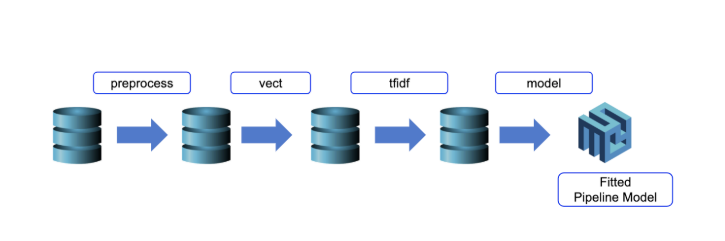

A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator. These stages are run in order, and the input DataFrame is transformed as it passes through each stage. That is, the data are passed through the fitted pipeline in order. Each stage’s transform() method updates the dataset and passes it to the next stage. With the help of Pipelines, we can ensure that training and test data go through identical feature processing steps.

Now let’s see how this can be done in Spark NLP using Annotators and Transformers. Assume that we have the following steps that need to be applied one by one on a data frame.

- Split text into sentences
- Tokenize

And here is how we code this pipeline up in Spark NLP.

In [66]:
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")

sentenceDetector = SentenceDetector().\
setInputCols(['document']).\
setOutputCol('sentences')

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("token")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 sentenceDetector,
 tokenizer
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [67]:
spark_df = spark.read.text('./sample-sentences-en.txt').toDF('text')

spark_df.show(truncate=False)

In [68]:
result = pipelineModel.transform(spark_df)

In [69]:
result.show(truncate=20)

In [70]:
result.printSchema()

In [71]:
result.select('sentences.result').take(3)

In [72]:
result.select('token').take(3)[2]

## Normalizer

Removes all dirty characters from text following a regex pattern and transforms words based on a provided dictionary

`setCleanupPatterns(patterns)`: Regular expressions list for normalization, defaults [^A-Za-z]

`setLowercase(value)`: lowercase tokens, default false

`setSlangDictionary(path)`: txt file with delimited words to be transformed into something else

In [75]:
import string
string.punctuation

In [76]:
from sparknlp.annotator import *

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(True)\
    .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
    # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])


In [77]:
from sparknlp.base import *

documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")


In [78]:

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 normalizer
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [79]:
result = pipelineModel.transform(spark_df)

In [80]:
result.show(truncate=20)

In [81]:
result.select('normalized.result').take(3)

## Stopwords Cleaner

This annotator excludes from a sequence of strings (e.g. the output of a Tokenizer, Normalizer, Lemmatizer, and Stemmer) and drops all the stop words from the input sequences.

Functions:

`setStopWords`: The words to be filtered out. Array[String]

`setCaseSensitive`: Whether to do a case sensitive comparison over the stop words.

In [85]:
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)\
      #.setStopWords(["no", "without"]) (e.g. read a list of words from a txt)


In [86]:
documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stopwords_cleaner
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [87]:
spark_df = spark.read.text('./sample-sentences-en.txt').toDF('text')

result = pipelineModel.transform(spark_df)

result.show()

## Token Assembler

In [89]:
documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")

sentenceDetector = SentenceDetector().\
    setInputCols(['document']).\
    setOutputCol('sentences')

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")\
    .setLowercase(False)\

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)\

tokenassembler = TokenAssembler()\
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("clean_text")


nlpPipeline = Pipeline(stages=[
     documentAssembler,
    sentenceDetector,
     tokenizer,
     normalizer,
     stopwords_cleaner,
     tokenassembler
 ])


empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(spark_df)

result.show()

In [90]:
result.select('text', 'clean_text.result').show(truncate=False)

In [91]:
import pyspark.sql.functions as F

result.withColumn(
    "tmp", 
    F.explode("clean_text")) \
    .select("tmp.*").select("begin","end","result","metadata.sentence").show(truncate = False)

In [92]:
# if we hadn't used Sentence Detector, this would be what we got. (tokenizer gets document instead of sentences column)

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")


nlpPipeline = Pipeline(stages=[
     documentAssembler,
     tokenizer,
     normalizer,
     stopwords_cleaner,
     tokenassembler
 ])


empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(spark_df)

result.select('text', 'clean_text.result').show(truncate=False)

In [93]:

result.withColumn(
    "tmp", 
    F.explode("clean_text")) \
    .select("tmp.*").select("begin","end","result","metadata.sentence").show(truncate = False)

## Stemmer

Returns hard-stems out of words with the objective of retrieving the meaningful part of the word

In [96]:
stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")

In [97]:
documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [98]:
result = pipelineModel.transform(spark_df)

result.show()

In [99]:
result.select('stem.result').show(truncate=False)

In [100]:
import pyspark.sql.functions as F

result_df = result.select(F.explode(F.arrays_zip('token.result', 'stem.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("stem")).toPandas()

result_df.head(10)

## Lemmatizer

Retrieves lemmas out of words with the objective of returning a base dictionary word

In [103]:
!wget https://raw.githubusercontent.com/mahavivo/vocabulary/master/lemmas/AntBNC_lemmas_ver_001.txt

In [104]:
lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")

In [105]:
documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [106]:
result = pipelineModel.transform(spark_df)

result.show()

In [107]:
result.select('lemma.result').show(truncate=False)

In [108]:
result_df = result.select(F.explode(F.arrays_zip('token.result', 'stem.result',  'lemma.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("stem"),
        F.expr("cols['2']").alias("lemma")).toPandas()

result_df.head(10)

## NGram Generator

NGramGenerator annotator takes as input a sequence of strings (e.g. the output of a `Tokenizer`, `Normalizer`, `Stemmer`, `Lemmatizer`, and `StopWordsCleaner`). 

The parameter n is used to determine the number of terms in each n-gram. The output will consist of a sequence of n-grams where each n-gram is represented by a space-delimited string of n consecutive words with annotatorType `CHUNK` same as the Chunker annotator.

Functions:

`setN:` number elements per n-gram (>=1)

`setEnableCumulative:` whether to calculate just the actual n-grams or all n-grams from 1 through n

`setDelimiter:` Glue character used to join the tokens

In [111]:

ngrams_cum = NGramGenerator() \
            .setInputCols(["token"]) \
            .setOutputCol("ngrams") \
            .setN(3) \
            .setEnableCumulative(True)\
            .setDelimiter("_") # Default is space
    
# .setN(3) means, take bigrams and trigrams.

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 ngrams_cum
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(spark_df)

result.select('ngrams.result').show(truncate=200)

## TextMatcher

Annotator to match entire phrases (by token) provided in a file against a Document

Functions:

`setEntities(path, format, options)`: Provides a file with phrases to match. Default: Looks up path in configuration.

`path`: a path to a file that contains the entities in the specified format.

`readAs`: the format of the file, can be one of {ReadAs.LINE_BY_LINE, ReadAs.SPARK_DATASET}. Defaults to LINE_BY_LINE.

`options`: a map of additional parameters. Defaults to {“format”: “text”}.

In [114]:
! wget 	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed-sample.csv


In [115]:
import pyspark.sql.functions as F

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("/tmp/pubmed-sample.csv")\
                .filter("AB IS NOT null")\
                .withColumnRenamed("AB", "text")\
                .drop("TI")

pubMedDF.show(truncate=50)

In [116]:
pubMedDF.select('text').take(1)

In [117]:
# write the target entities to txt file 

entities = ['KCNJ9', 'GIRK', 'diabetes mellitus', 'nucleotide polymorphisms']
with open ('clinical_entities.txt', 'w') as f:
    for i in entities:
        f.write(i+'\n')

In [118]:

entity_extractor = TextMatcher() \
    .setInputCols(["document",'token'])\
    .setOutputCol("matched_entities")\
    .setEntities("clinical_entities.txt")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 entity_extractor
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


In [119]:
result = pipelineModel.transform(pubMedDF.limit(10))

In [120]:
result.select('matched_entities.result').take(1)

In [121]:
result_df = result.select(F.explode(F.arrays_zip('matched_entities.result', 'matched_entities.begin',  'matched_entities.end')).alias("cols")) \
.select(F.expr("cols['0']").alias("matched_entities"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end")).toPandas()

result_df.head(10)

## RegexMatcher

In [123]:
rules = '''
renal\s\w+, followed by 'renal'
cardiac\s\w+, followed by 'cardiac'
'''

with open('regex_rules.txt', 'w') as f:
    
    f.write(rules)
    

In [124]:
import os

documentAssembler = DocumentAssembler()\
.setInputCol("text")\
.setOutputCol("document")

regex_matcher = RegexMatcher()\
    .setInputCols('document')\
    .setStrategy("MATCH_ALL")\
    .setOutputCol("regex_matches")\
    .setExternalRules(path='./regex_rules.txt', delimiter=',')
    

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 regex_matcher
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

match_df = pipelineModel.transform(pubMedDF)

match_df.select('regex_matches.result').take(3)

In [125]:
match_df.select('text','regex_matches.result')\
.toDF('text','matches').filter(F.size('matches')>1)\
.show(truncate=50)


## Text Cleaning with UDF

In [127]:
text = '<h1 style="color: #5e9ca0;">Have a great <span  style="color: #2b2301;">birth</span> day!</h1>'

text_df = spark.createDataFrame([[text]]).toDF("text")


import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType


clean_text = lambda s: re.sub(r'<[^>]*>', '', s)


text_df.withColumn('cleaned', udf(clean_text, StringType())('text')).select('text','cleaned').show(truncate= False)



In [128]:
find_not_alnum_count = lambda s: len([i for i in s if not i.isalnum() and i!=' '])

find_not_alnum_count("it's your birth day!")

In [129]:
text = '<h1 style="color: #5e9ca0;">Have a great <span  style="color: #2b2301;">birth</span> day!</h1>'

find_not_alnum_count(text)

In [130]:
text_df.withColumn('cleaned', udf(find_not_alnum_count, IntegerType())('text')).select('text','cleaned').show(truncate= False)

## Finisher

***Finisher:*** Once we have our NLP pipeline ready to go, we might want to use our annotation results somewhere else where it is easy to use. The Finisher outputs annotation(s) values into a string.

If we just want the desired output column in the final dataframe, we can use Finisher to drop previous stages in the final output and gte the `result` from the process.

This is very handy when you want to use the output from Spark NLP annotator as an input to another Spark ML transformer.

Settable parameters are:

`setInputCols()`

`setOutputCols()`

`setCleanAnnotations(True)` -> Whether to remove intermediate annotations

`setValueSplitSymbol(“#”)` -> split values within an annotation character

`setAnnotationSplitSymbol(“@”)` -> split values between annotations character

`setIncludeMetadata(False)` -> Whether to include metadata keys. Sometimes useful in some annotations.

`setOutputAsArray(False)` -> Whether to output as Array. Useful as input for other Spark transformers.

In [133]:
finisher = Finisher() \
    .setInputCols(["regex_matches"]) \
    .setIncludeMetadata(False) # set to False to remove metadata

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 regex_matcher,
 finisher
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

match_df = pipelineModel.transform(pubMedDF)

match_df.show(truncate = 50)

In [134]:
match_df.printSchema()

In [135]:
match_df.filter(F.size('finished_regex_matches')>1).show(truncate = 50)

## LightPipeline

LightPipelines are Spark NLP specific Pipelines, equivalent to Spark ML Pipeline, but meant to deal with smaller amounts of data. They’re useful working with small datasets, debugging results, or when running either training or prediction from an API that serves one-off requests.

Spark NLP LightPipelines are Spark ML pipelines converted into a single machine but the multi-threaded task, becoming more than 10x times faster for smaller amounts of data (small is relative, but 50k sentences are roughly a good maximum). To use them, we simply plug in a trained (fitted) pipeline and then annotate a plain text. We don't even need to convert the input text to DataFrame in order to feed it into a pipeline that's accepting DataFrame as an input in the first place. This feature would be quite useful when it comes to getting a prediction for a few lines of text from a trained ML model.

 **It is nearly 20x faster than using Spark ML Pipeline**

`LightPipeline(someTrainedPipeline).annotate(someStringOrArray)`

In [138]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate("John and Peter are brothers. However they don't support each other that much.")

In [139]:
light_result.keys()

In [140]:
list(zip(light_result['token'], light_result['stem'], light_result['lemma']))

In [141]:
light_result = light_model.fullAnnotate("John and Peter are brothers. However they don't support each other that much.")

In [142]:
light_result

In [143]:
text_list= ["How did serfdom develop in and then leave Russia ?",
"There will be some exciting breakthroughs in NLP this year."]

light_model.annotate(text_list)